# This notebook gives an introduction to the xcube's "zenodo" data store and its preload_data method

This notebook shows an example how to preload compressed files published on the [https://zenodo.org](https://zenodo.org) webpage. The compressed files will be downloaded, unpacked and the the individual files will be made available as a Zarr file, which can be subsequently used by the data store as usual. 

### Setup
In order to run this notebook you need to get an access token for the Zenodo API following the [documentation](https://zenodo.org/login/?next=%2Faccount%2Fsettings%2Fapplications%2Ftokens%2Fnew%2F). Furthermore, make sure that [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) is installed. You may install [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) directly from the git repository by cloning the repository, directing into `xcube-zenodo`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-zenodo
pip install .
```

Note that [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store
from xcube.core.store import get_data_store_params_schema
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Log format
    datefmt='%Y-%m-%d %H:%M:%S',  # Timestamp format
)

CPU times: user 6.81 s, sys: 919 ms, total: 7.73 s
Wall time: 7.05 s


First, we get the store parameters needed to initialize a zenodo [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). 

In [2]:
%%time
store_params = get_data_store_params_schema("zenodo")
store_params

CPU times: user 109 ms, sys: 22.2 ms, total: 132 ms
Wall time: 130 ms


We initiate a zenodo [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). Note that the `xcube-zenodo` plugin is recognized after installation by setting the first argument to `"zenodo"` in the `new_data_store` function. We can optionally specify the cache data store's ID and parameters using the `cache_store_id` and `cache_store_params` keyword arguments. By default, `cache_store_id` is set to `file`, and `cache_store_params` defaults to `dict(root="zenodo_cache", max_depth=3)`.

In [3]:
%%time
store = new_data_store("zenodo")

CPU times: user 61.8 ms, sys: 4.84 ms, total: 66.6 ms
Wall time: 71 ms


Compressed files can be preloaded using the `preload_data` method. Also this method uses `preload_params`, which can be viewed in the next cell.

In [4]:
%%time
preload_params = store.get_preload_data_params()
preload_params

CPU times: user 106 μs, sys: 14 μs, total: 120 μs
Wall time: 127 μs


 This approach enables the downloading of compressed files that cannot be lazily loaded, allowing them to be stored and readily available for the duration of the project. The `preload_data` method is non-blocking and returns a handler which can be used to cancel the preload by typing `handler.cancel()` indto the next cell. Note that the `preload_method` is new and highly experimental.

In [5]:
handler = store.preload_data("13333034/belgium.zip", "13333034/denmark.zip")

Data ID,Status,Progress,Message
13333034/belgium.zip,Preloaded,nan%,
13333034/denmark.zip,Preloaded,nan%,


The data IDs can be view by using the following line. Note that in this example the zipped file contains multiple files. If this is the case and `merge=False` (which is the default), each file is written to a Zarr file. The data ID is extended by the individual file names where the file extension is adjusted. 

In [6]:
store.cache_store.list_data_ids()

['13333034/belgium/number_disturbances_belgium.zarr',
 '13333034/belgium/annual_disturbances_1985_2023_belgium.zarr',
 '13333034/belgium/latest_disturbance_belgium.zarr',
 '13333034/belgium/disturbance_agent_1985_2023_belgium.zarr',
 '13333034/belgium/forest_mask_belgium.zarr',
 '13333034/belgium/disturbance_agent_aggregated_belgium.zarr',
 '13333034/belgium/greatest_disturbance_belgium.zarr',
 '13333034/belgium/disturbance_probability_1985_2023_belgium.zarr',
 '13333034/belgium/disturbance_severity_1985_2023_belgium.zarr',
 '13333034/denmark/disturbance_severity_1985_2023_denmark.zarr',
 '13333034/denmark/latest_disturbance_denmark.zarr',
 '13333034/denmark/number_disturbances_denmark.zarr',
 '13333034/denmark/greatest_disturbance_denmark.zarr',
 '13333034/denmark/forest_mask_denmark.zarr',
 '11546130/mergedlabels.zarr',
 '11546130/EventCube_ranked_pot0.01_ne0.1.zarr']

Next we want to open one of the datasets. We first view the availbale parameters to open the data. 

In [7]:
%%time
open_params = store.get_open_data_params_schema(data_id="13333034/belgium/disturbance_probability_1985_2023_belgium.zarr")
open_params

CPU times: user 2.32 ms, sys: 866 μs, total: 3.18 ms
Wall time: 2.61 ms


In [8]:
%%time
ds = store.open_data("13333034/belgium/disturbance_probability_1985_2023_belgium.zarr")
ds

CPU times: user 24.9 ms, sys: 2.15 ms, total: 27.1 ms
Wall time: 26.7 ms


<xarray.Dataset> Size: 27GB
Dimensions:      (y: 9084, x: 9390)
Coordinates:
    spatial_ref  int64 8B ...
  * x            (x) float64 75kB 3.795e+06 3.795e+06 ... 4.076e+06 4.076e+06
  * y            (y) float64 73kB 3.189e+06 3.189e+06 ... 2.917e+06 2.917e+06
Data variables: (12/39)
    band_1       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_10      (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_11      (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_12      (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_13      (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_14      (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    ...           ...
    band_4       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_5       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_6       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_7       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_8       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
    band_9       (y, x) float64 682MB dask.array<chunksize=(512, 512), meta=np.ndarray>
Attributes:
    source:   file:///home/konstantin/bc_kon/01_coding/01_github/xcube-zenodo...

We plot parts of the opened data as an example below.

CPU times: user 3.67 s, sys: 337 ms, total: 4 s
Wall time: 929 ms


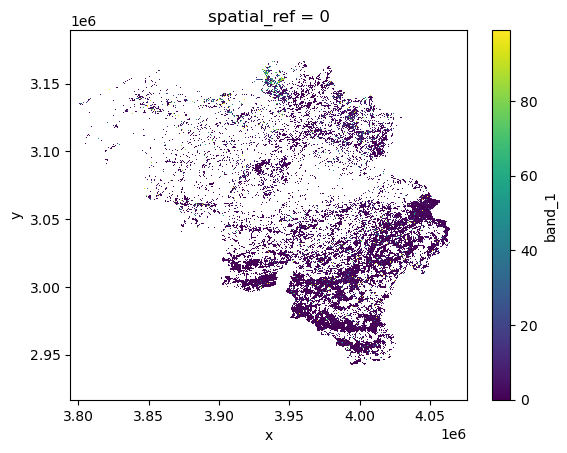

In [9]:
%%time
ds.band_1[::10, ::10].plot()